<h2>Learning-Based View Synthesis for Light Field Cameras (Kalantari et al. 2016)</h2>
<h4>Implementation by Dylan Rowe</h4>

<h3>Imports</h3>

In [1]:
import os
import numpy as np
import math
import random
import torch
from torch import nn, optim
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))    
if device == 'cuda:0':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# device = 'cpu'

Using cuda:0 device
GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
# plt.figure(figsize=(24, 16))
# im1 = plt.imread('../../../../../datasets/cs274-fa21-A00-public/TrainingSet/STANFORD/bikes_9_eslf.png')
# numImgsX = 14
# numImgsY = 14
# h = int(im1.shape[0] / numImgsY)
# w = int(im1.shape[1] / numImgsX)
# fullLF = np.zeros((h, w, 3, numImgsX, numImgsY))
# for ax in range(numImgsX):
#     for ay in range(numImgsY):
#         #print(im1[ay::numImgsY, ax::numImgsX, :].shape)
#         fullLF[:,:,:, ax, ay] = im1[ay::numImgsY, ax::numImgsX, :3]
# if h == 375 and w == 540:
#     np.pad(fullLF, ((0, 1), (0, 1), (0, 0), (0, 0), (0, 0)))
# if h == 375 and w == 541:
#     np.pad(fullLF, ((0, 1), (0, 0), (0, 0), (0, 0), (0, 0)))
# fullLF = fullLF[:, :, :, 4:12, 4:12] # 8 middle images
# print the full LF
# nrows = 8
# ncols = 8
# for i in range(8):
#     for j in range(8):
#         ax = plt.subplot(nrows, ncols, i*ncols + j + 1)
#         ax.set_xticks([])
#         ax.set_yticks([])
#         plt.imshow(fullLF[:, :, :, i, j])
# plt.subplots_adjust(wspace=0, hspace=0)
# plt.show()
# print the input LF
# nrows = 2
# ncols = 2
# plt.subplot(221)
# plt.imshow(fullLF[:,:,:,0,0])
# plt.subplot(222)
# plt.imshow(fullLF[:,:,:,0,7])
# plt.subplot(223)
# plt.imshow(fullLF[:,:,:,7,0])
# plt.subplot(224)
# plt.imshow(fullLF[:,:,:,7,7])
# plt.show()

In [3]:
train_ours = os.listdir('../../../../../datasets/cs274-fa21-A00-public/TrainingSet/OURS')
train_stanf = os.listdir('../../../../../datasets/cs274-fa21-A00-public/TrainingSet/STANFORD')
test_paper = os.listdir('../../../../../datasets/cs274-fa21-A00-public/TestSet/PAPER')
test_extra = os.listdir('../../../../../datasets/cs274-fa21-A00-public/TestSet/EXTRA')
# print(train_ours)
train_dir = '../../../../../datasets/cs274-fa21-A00-public/TrainingSet/'
test_dir = '../../../../../datasets/cs274-fa21-A00-public/TestSet/'
names = ["OURS/"+a for a in train_ours] + ["STANFORD/"+b for b in train_stanf]
test_names = ["PAPER/"+a for a in test_paper] + ["EXTRA/"+b for b in test_extra]
print(test_names)

['PAPER/Cars.png', 'PAPER/Flower1.png', 'PAPER/Flower2.png', 'PAPER/Seahorse.png', 'PAPER/Rock.png', 'EXTRA/IMG_1528_eslf.png', 'EXTRA/IMG_1586_eslf.png', 'EXTRA/IMG_1184_eslf.png', 'EXTRA/IMG_1324_eslf.png', 'EXTRA/IMG_1541_eslf.png', 'EXTRA/IMG_1312_eslf.png', 'EXTRA/IMG_1086_eslf.png', 'EXTRA/IMG_1325_eslf.png', 'EXTRA/IMG_1316_eslf.png', 'EXTRA/IMG_1306_eslf.png', 'EXTRA/IMG_1555_eslf.png', 'EXTRA/IMG_1085_eslf.png', 'EXTRA/IMG_1411_eslf.png', 'EXTRA/IMG_1321_eslf.png', 'EXTRA/IMG_1419_eslf.png', 'EXTRA/IMG_1390_eslf.png', 'EXTRA/IMG_1743_eslf.png', 'EXTRA/IMG_1389_eslf.png', 'EXTRA/IMG_1327_eslf.png', 'EXTRA/IMG_1328_eslf.png', 'EXTRA/IMG_1317_eslf.png', 'EXTRA/IMG_1340_eslf.png', 'EXTRA/IMG_1554_eslf.png', 'EXTRA/IMG_1187_eslf.png', 'EXTRA/IMG_1320_eslf.png']


<h3>Light Field Dataloader</h3>

In [4]:
patchSize = 60
patchStride = 16

disparity_levels = 100
disparity_range = (-21, 21)
n = 4

def back_warp(L_pi, q, d):
    # used to create features
    # given h x w x 3 x 4 lightfield views, output h x w x 3 x 4 x L (L=100 disparity levels) tensor
    # At each last index k, the image represents that view warped by disparity level k
    # q is the novel view pos; d is a linspace of 100 disparity levels -21, ... , 21
    h, w = L_pi.shape[:2]
    xs = torch.linspace(0, w, steps=w)
    ys = torch.linspace(0, h, steps=h)
    y, x = torch.meshgrid(ys, xs)
    x = x.repeat(100, 1, 1).transpose(0, 1).transpose(1, 2) # size h x w x 100
    y = y.repeat(100, 1, 1).transpose(0, 1).transpose(1, 2)
    L_pi = torch.permute(L_pi, (3, 2, 0, 1)) # 4 x 3 x h x w for grid_sample
    back_warped = torch.zeros(h, w, 1, 4, disparity_levels)
    for i in range(4):
        pi = torch.tensor([0 if (i == 0 or i == 2) else 7, 0 if (i == 0 or i == 1) else 7])
#         print(pi.shape)
#         print(q.shape)
#         print(d.shape)
#         print(x.shape)
        xd = x + (pi[0]-q[0])*d
        yd = y + (pi[1]-q[1])*d
        # grid sample assumes top left is -1, -1 and bottom right is 1, 1
        xd = torch.clamp((xd*2.0/w) - 1.0, min=-1, max=1)
        yd = torch.clamp((yd*2.0/h) - 1.0, min=-1, max=1)
        grid = torch.stack((xd, yd), dim=3) # h x w x 100 x 2
        grid = torch.permute(grid, (2, 0, 1, 3)) # 100 x h x w x 2 for grid_sample
        back_warped[:, :, :, i, :] = torch.permute(
            F.grid_sample(L_pi[i, :, :, :].unsqueeze(0).repeat(disparity_levels, 1, 1, 1), # d x 3 x h x w
                          grid, # d x h x w x 2
                          mode='bicubic'), 
            (2, 3, 1, 0)) # grid sample outputs d x 3 x h x w
    return back_warped # h x w x 3 x 4 x disparity_levels

class LightFieldDataSet(Dataset):
    def __init__(self, img_dir, img_names):
        self.img_dir = img_dir
        self.img_names = img_names
    def __len__(self):
        return len(self.img_names)
    def __getitem__(self, idx):
        with torch.no_grad():
            # LOAD THE IMAGE AND TURN IT FROM LIGHTFIELD TO SEPARATED IMAGES
            img_path = os.path.join(self.img_dir, self.img_names[idx])#'/'.join(self.img_dir, self.img_names[idx])#self.img_dir, self.img_names[idx])
            image = plt.imread(img_path)
            numImgsX = 14
            numImgsY = 14
            h = int(image.shape[0] / numImgsY)
            w = int(image.shape[1] / numImgsX)
            fullLF = np.zeros((h, w, 3, numImgsX, numImgsY))
            for ax in range(numImgsX):
                for ay in range(numImgsY):
                    #print(im1[ay::numImgsY, ax::numImgsX, :].shape)
                    fullLF[:,:,:, ax, ay] = image[ay::numImgsY, ax::numImgsX, :3]
            if h == 375 and w == 540:
                np.pad(fullLF, ((0, 1), (0, 1), (0, 0), (0, 0), (0, 0)))
            if h == 375 and w == 541:
                np.pad(fullLF, ((0, 1), (0, 0), (0, 0), (0, 0), (0, 0)))
            fullLF = fullLF[:, :, :, 4:12, 4:12] # 8 middle images
            inr = np.array(((0, 0), (7, 7)))
            inc = np.array(((0, 7), (0, 7)))
            inLF = fullLF[:, :, :, inc, inr] # 4 corner images
    #         print(inLF.shape)

            # CONVERT FULL AND INPUT LIGHTFIELDS TO TENSORS
            fullTens = torch.from_numpy(fullLF).float() # should be h x w x 3 x 8 x 8
            inTens = torch.from_numpy(inLF).float() # h x w x 3 x 2 x 2

            # CREATE THE INPUT, FEATURE, GROUND TRUTH PATCHES, AND REFERENCE VIEW FOR THE NETWORK
            # create input patches
            inP = torch.reshape(inTens, (h, w, 3, -1))
            inP = inP.unfold(0, patchSize, patchStride).unfold(1, patchSize, patchStride)
            inP = torch.flatten(inP, start_dim=0, end_dim=1)

            # choose random q
            q = [0, 0]
#             while q[0] == 0 or q[0] == 7 or q[1] == 0 or q[1] == 7: # early training is only on non-corner views
            q[0] = random.randrange(8)
            q[1] = random.randrange(8)
            q = torch.tensor(q)

            # create feature patches
            disps = torch.linspace(disparity_range[0], disparity_range[1], 100)
            inTens_gray = 0.299*inTens[:, :, 0, :, :] + 0.587*inTens[:, :, 1, :, :] + 0.114*inTens[:, :, 2, :, :] #gray
            warped = back_warp(torch.reshape(inTens_gray, (h, w, 1, -1)), q, disps) # h x w x 3(1) x 4 x disparity_levels
            warped = torch.squeeze(warped) # remove singleton dimension... gives h x w x 4 x disparity_levels
            mean_feat = torch.mean(warped, dim=2)
            stdev_feat = torch.sqrt((1.0/3.0)*torch.sum(torch.pow(warped - mean_feat.unsqueeze(2), 2), dim=2))
            featP = torch.cat((mean_feat, stdev_feat), dim=2).unfold(0, patchSize, patchStride).unfold(1, patchSize, patchStride)
            featP = torch.flatten(featP, start_dim=0, end_dim=1)
            
            # create gt patches
            gtP = fullTens[:, :, :, q[0], q[1]].unfold(0, patchSize, patchStride).unfold(1, patchSize, patchStride)
            gtP = torch.flatten(gtP, start_dim=0, end_dim=1)[:, :, 12:48, 12:48] # output patches are 36x36
            
#             print("inP")
#             print(inP.shape)
#             print("featP")
#             print(featP.shape)
#             print("gtP")
#             print(gtP.shape)
#             print("q")
#             print(q.shape)
            
            # randomly permute the tensors for training
            perm = torch.randperm(inP.shape[0])
            inP = inP[perm, :, :, :, :]
            featP = featP[perm, :, :, :]
            gtP = gtP[perm, :, :, :]

            return [inP, featP, gtP, q]

# train_ours = LightFieldDataSet('../../../../../datasets/cs274-fa21-A00-public/TrainingSet/OURS')
# train_stanf = LightFieldDataSet('../../../../../datasets/cs274-fa21-A00-public/TrainingSet/STANFORD')
trainset = LightFieldDataSet(train_dir, names)
testset = LightFieldDataSet(test_dir, test_names)

train_dataloader = DataLoader(trainset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=1, shuffle=True)

<h3>Disparity and Color Estimation Networks</h3>

In [5]:
class DispEst(nn.Module):
    def __init__(self):
        super(DispEst, self).__init__()
        self.c1 = nn.Conv2d(200, 100, 7)
        self.c2 = nn.Conv2d(100, 100, 5)
        self.c3 = nn.Conv2d(100, 50, 3)
        self.c4 = nn.Conv2d(50, 1, 1)
        
    def forward(self, x):
        # x is n x 200 x h x w
        # go through the layers, relu after each:
        x = self.c1(x)
        x = F.relu(x)
        x = self.c2(x)
        x = F.relu(x)
        x = self.c3(x)
        x = F.relu(x)
        x = self.c4(x)
        
        return x
    
class ColorEst(nn.Module):
    def __init__(self):
        super(ColorEst, self).__init__()
        self.c1 = nn.Conv2d(3*4 + 3, 100, 7)
        self.c2 = nn.Conv2d(100, 100, 5)
        self.c3 = nn.Conv2d(100, 50, 3)
        self.c4 = nn.Conv2d(50, 3, 1)
        
    def forward(self, x):
        # x is n x 3N+3 x h x w
        # go through the layers, relu after each:
        x = self.c1(x)
        x = F.relu(x)
        x = self.c2(x)
        x = F.relu(x)
        x = self.c3(x)
        x = F.relu(x)
        x = self.c4(x)
        
        return x
    
def forward_warp(inp, q, disp):
    # inp is n x 3 x 4 x 60 x 60
    # q is 2,
    # disp is n x 1 x 60 x 60 (?)
    ph, pw = disp.shape[2:]
    xs = torch.linspace(0, pw, steps=pw)
    ys = torch.linspace(0, ph, steps=ph)
    y, x = torch.meshgrid(ys, xs)
    y = y.repeat(disp.shape[0], 1, 1) # n x 60 x 60
    x = x.repeat(disp.shape[0], 1, 1)
    out = torch.zeros(inp.shape[0], 3*4, ph, pw).to(device)# n x 3*4 x 60 x 60
    for i in range(4):
        pi = torch.tensor([0 if (i == 0 or i == 2) else 7, 0 if (i == 0 or i == 1) else 7])
        # send x, y, pi to device
        x = x.to(device)
        y = y.to(device)
        pi = pi.to(device)
        xd = x + (pi[0]-q[0])*disp.squeeze() # still n x 60 x 60
        yd = y + (pi[1]-q[1])*disp.squeeze()
        # grid sample assumes top left is -1, -1 and bottom right is 1, 1
        xd = torch.clamp((xd*2.0/pw) - 1.0, min=-1, max=1)
        yd = torch.clamp((yd*2.0/ph) - 1.0, min=-1, max=1)
        grid = torch.stack((xd, yd), dim=3) # n x 60 x 60 x 2
        out[:, 3*i:3*i+3, :, :] = F.grid_sample(inp[:, :, i, :, :], grid, mode='bicubic')
    return out
    
class DispColorNet(nn.Module):
    def __init__(self):
        super(DispColorNet, self).__init__()
        self.d = DispEst()
        self.c = ColorEst()
    def forward(self, x, feat_d, q):
        # disparity estimation network takes in n x 200 x h x w features, outputs n x 1 x h x w disparity
        disp = self.d(feat_d)
        
        # forward warp, cat with disp and q: n x 3*4+3 x h x w
        fw = forward_warp(x, q, disp)
        q_rep = q[None, :, None, None].repeat((fw.shape[0], 1, fw.shape[2], fw.shape[3])) # n x 2 x h x w
        feat_c = torch.cat((fw, disp, q_rep), dim=1)
        
        # color estimation network takes in n x 3*4+3 x h x w, outputs n x 3 x h-12, w-12
        out = self.c(feat_c)
        
        return out

<h3>Training Loop</h3>

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[151,     0] train loss: 133.1021972817
[151,    20] train loss: 39.5658722372
[151,    40] train loss: 105.1253919040
[151,    60] train loss: 30.7848074828
[151,    80] train loss: 41.3978603164
Calculating test loss...
Done with epoch 151.  Test loss did not improve: 23.0908591222; not checkpointing
train loss progress:


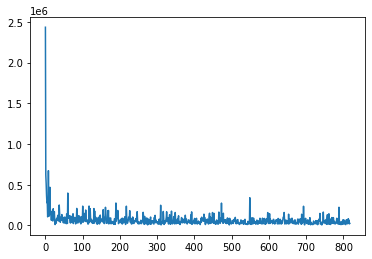

test loss progress:


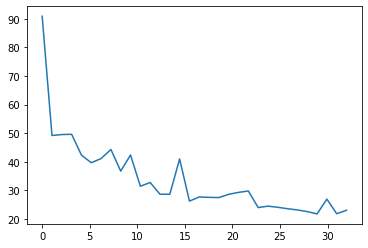

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[152,     0] train loss: 82.8629683838
[152,    20] train loss: 31.9036888081
[152,    40] train loss: 108.9812957110
[152,    60] train loss: 85.2475513817
[152,    80] train loss: 48.1985026059
[153,     0] train loss: 84.7562618987
[153,    20] train loss: 17.0568019245
[153,    40] train loss: 96.6611819997
[153,    60] train loss: 82.1933794034
[153,    80] train loss: 54.9847872251
[154,     0] train loss: 41.8477103314
[154,    20] train loss: 12.6197125632
[154,    40] train loss: 69.1049990150
[154,    60] train loss: 80.7157866827
[154,    80] train loss: 37.3999465323
[155,     0] train loss: 28.7060101175
[155,    20] train loss: 65.6918609200
[155,    40] train loss: 23.7312890546
[155,    60] train loss: 41.2292872329
[155,    80] train loss: 61.9682412256
Calculating test loss...
Done with epoch 155.  Test loss did not improve: 27.5683244834; not checkpointing
[156,     0] train loss: 133.3513946901
[156,    20] train loss: 157.7940360814
[156,    40] train loss: 17.9719

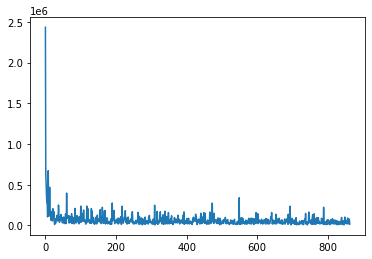

test loss progress:


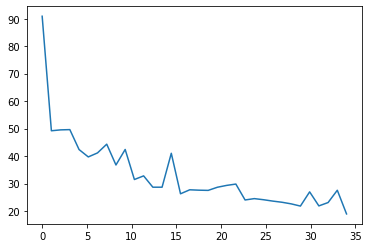

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[161,     0] train loss: 56.3214674220
[161,    20] train loss: 88.3093692095
[161,    40] train loss: 18.4838525633
[161,    60] train loss: 67.7570086454
[161,    80] train loss: 77.8973641743
[162,     0] train loss: 85.0118914687
[162,    20] train loss: 21.9396294375
[162,    40] train loss: 24.4427350078
[162,    60] train loss: 28.5326401552
[162,    80] train loss: 107.6484669481
[163,     0] train loss: 52.0070500254
[163,    20] train loss: 107.3941732834
[163,    40] train loss: 20.5318732384
[163,    60] train loss: 104.1689443766
[163,    80] train loss: 30.9753580800
[164,     0] train loss: 52.6139691251
[164,    20] train loss: 21.4983136983
[164,    40] train loss: 40.1753700804
[164,    60] train loss: 36.6362080632
[164,    80] train loss: 42.7932256625
[165,     0] train loss: 188.8036007365
[165,    20] train loss: 107.0185276717
[165,    40] train loss: 29.6994923125
[165,    60] train loss: 34.6420114518
[165,    80] train loss: 11.4992936312
Calculating test los

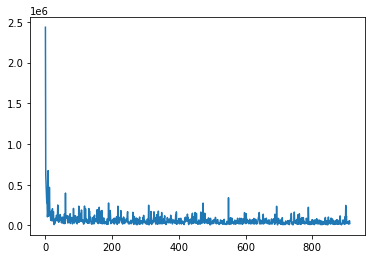

test loss progress:


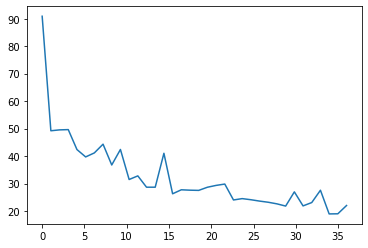

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[171,     0] train loss: 39.3459634678
[171,    20] train loss: 58.2779365056
[171,    40] train loss: 90.0623394933
[171,    60] train loss: 95.5692228935
[171,    80] train loss: 129.1222465190
[172,     0] train loss: 93.7484964540
[172,    20] train loss: 44.2773656502
[172,    40] train loss: 125.1485743830
[172,    60] train loss: 39.2082955035
[172,    80] train loss: 27.5487718633
[173,     0] train loss: 37.1000997660
[173,    20] train loss: 36.9680924128
[173,    40] train loss: 44.1998917189
[173,    60] train loss: 121.9571057932
[173,    80] train loss: 49.1605536343
[174,     0] train loss: 131.7097721116
[174,    20] train loss: 70.6949453229
[174,    40] train loss: 100.1900004114
[174,    60] train loss: 40.0562851372
[174,    80] train loss: 145.1340622695
[175,     0] train loss: 49.8827756238
[175,    20] train loss: 24.9597560369
[175,    40] train loss: 51.6879103761
[175,    60] train loss: 32.1812711064
[175,    80] train loss: 82.5446419806
Calculating test lo

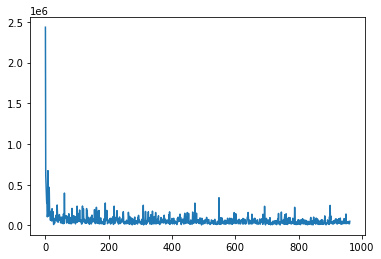

test loss progress:


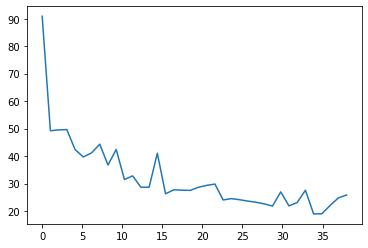

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[181,     0] train loss: 27.7099888904
[181,    20] train loss: 22.4801818256
[181,    40] train loss: 47.9970217356
[181,    60] train loss: 41.1789451583
[181,    80] train loss: 252.7486531543
[182,     0] train loss: 52.9644570688
[182,    20] train loss: 84.7933463813
[182,    40] train loss: 68.5109055037
[182,    60] train loss: 71.7211873863
[182,    80] train loss: 36.3861058679
[183,     0] train loss: 74.5643477990
[183,    20] train loss: 28.7843653324
[183,    40] train loss: 71.0090987542
[183,    60] train loss: 107.3818817091
[183,    80] train loss: 72.8119222432
[184,     0] train loss: 14.4261306588
[184,    20] train loss: 41.0327835760
[184,    40] train loss: 41.6215418905
[184,    60] train loss: 150.6942404962
[184,    80] train loss: 19.7386059079
[185,     0] train loss: 18.3547331904
[185,    20] train loss: 92.1202137597
[185,    40] train loss: 66.8412348962
[185,    60] train loss: 103.3738739433
[185,    80] train loss: 44.8472294481
Calculating test loss

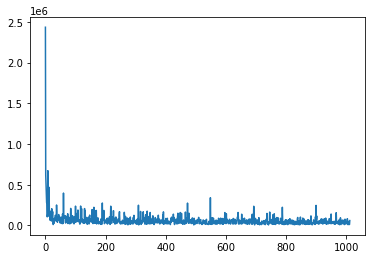

test loss progress:


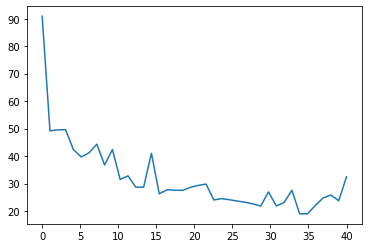

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[191,     0] train loss: 91.9124881440
[191,    20] train loss: 29.5182642381
[191,    40] train loss: 50.6527620127
[191,    60] train loss: 119.3514886129
[191,    80] train loss: 34.6806559761
[192,     0] train loss: 45.8535590867
[192,    20] train loss: 34.7441072359
[192,    40] train loss: 129.2828933612
[192,    60] train loss: 66.6017872218
[192,    80] train loss: 13.3243609847
[193,     0] train loss: 61.0588075476
[193,    20] train loss: 32.1661154672
[193,    40] train loss: 22.3324423147
[193,    60] train loss: 66.3784150372
[193,    80] train loss: 17.5121832364
[194,     0] train loss: 29.4445822499
[194,    20] train loss: 51.4998996657
[194,    40] train loss: 37.8158222584
[194,    60] train loss: 16.9088712734
[194,    80] train loss: 27.5150424364
[195,     0] train loss: 34.4003826372
[195,    20] train loss: 52.9847647466
[195,    40] train loss: 63.4556416757
[195,    60] train loss: 25.5754195688
[195,    80] train loss: 78.9690768334
Calculating test loss..

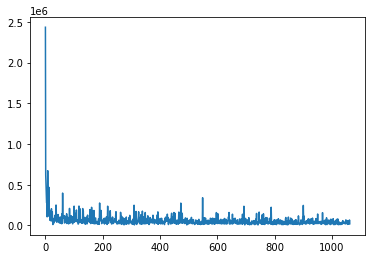

test loss progress:


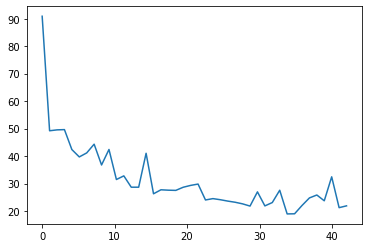

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[201,     0] train loss: 58.4273016845
[201,    20] train loss: 32.3820077603
[201,    40] train loss: 61.2584888863
[201,    60] train loss: 53.4065129801
[201,    80] train loss: 51.6556502437
[202,     0] train loss: 30.0231856267
[202,    20] train loss: 15.5719174762
[202,    40] train loss: 90.7708570831
[202,    60] train loss: 50.9977806992
[202,    80] train loss: 91.7227485036
[203,     0] train loss: 73.4125205627
[203,    20] train loss: 47.4624748472
[203,    40] train loss: 19.6097929331
[203,    60] train loss: 17.5211603212
[203,    80] train loss: 27.1715811056
[204,     0] train loss: 33.1768100266
[204,    20] train loss: 36.4424099152
[204,    40] train loss: 27.0797260005
[204,    60] train loss: 103.9922654496
[204,    80] train loss: 90.4743673566
[205,     0] train loss: 49.5960159130
[205,    20] train loss: 54.4169587247
[205,    40] train loss: 41.9648269616
[205,    60] train loss: 17.2941218141
[205,    80] train loss: 124.2383498024
Calculating test loss..

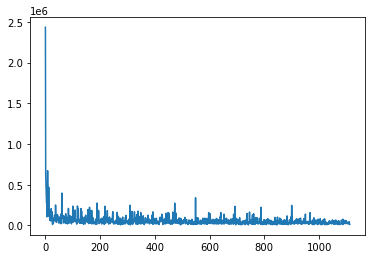

test loss progress:


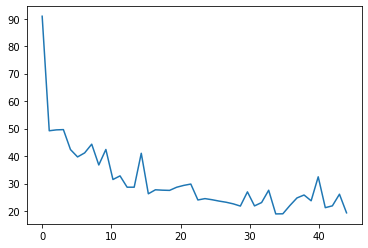

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[211,     0] train loss: 64.3569378570
[211,    20] train loss: 64.6613803195
[211,    40] train loss: 40.1614354091
[211,    60] train loss: 74.8637790446
[211,    80] train loss: 67.1089256467
[212,     0] train loss: 43.5110801213
[212,    20] train loss: 19.0913349343
[212,    40] train loss: 42.2435852662
[212,    60] train loss: 54.1669328999
[212,    80] train loss: 56.5395950047
[213,     0] train loss: 37.0087597199
[213,    20] train loss: 30.6210789562
[213,    40] train loss: 61.9187718879
[213,    60] train loss: 93.4471515483
[213,    80] train loss: 44.8457932110
[214,     0] train loss: 27.8444147065
[214,    20] train loss: 87.3593578118
[214,    40] train loss: 359.9840039429
[214,    60] train loss: 59.2996456298
[214,    80] train loss: 27.6059983709
[215,     0] train loss: 53.8537933477
[215,    20] train loss: 123.0028581913
[215,    40] train loss: 118.7374046274
[215,    60] train loss: 9.4874745984
[215,    80] train loss: 154.1699906903
Calculating test loss.

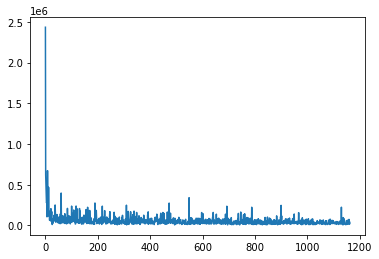

test loss progress:


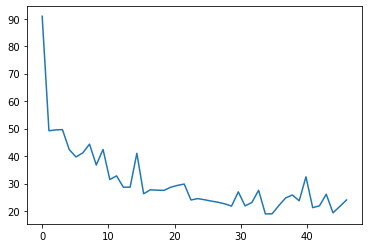

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[221,     0] train loss: 17.3384050334
[221,    20] train loss: 37.7430054066
[221,    40] train loss: 26.0417026600
[221,    60] train loss: 28.1470008326
[221,    80] train loss: 95.9178123170
[222,     0] train loss: 34.0857155511
[222,    20] train loss: 29.2918942484
[222,    40] train loss: 80.1535699858
[222,    60] train loss: 113.8132290499
[222,    80] train loss: 42.6665641589
[223,     0] train loss: 29.4706065499
[223,    20] train loss: 95.7091645769
[223,    40] train loss: 108.7609026507
[223,    60] train loss: 158.5111208516
[223,    80] train loss: 88.6214445794
[224,     0] train loss: 34.9427122134
[224,    20] train loss: 65.6236492269
[224,    40] train loss: 31.5195218628
[224,    60] train loss: 11.8158043863
[224,    80] train loss: 10.3863347809
[225,     0] train loss: 67.1228120294
[225,    20] train loss: 104.6038640640
[225,    40] train loss: 60.9756514248
[225,    60] train loss: 28.8896529920
[225,    80] train loss: 41.6156869342
Calculating test loss

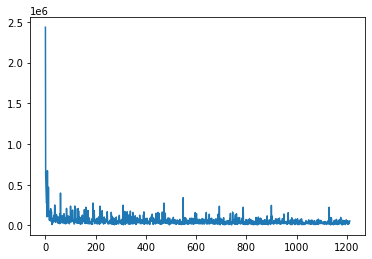

test loss progress:


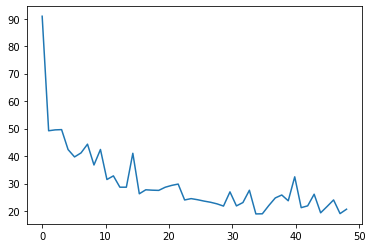

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[231,     0] train loss: 224.6805956084
[231,    20] train loss: 53.6664336492
[231,    40] train loss: 58.7760709543
[231,    60] train loss: 50.1995628331
[231,    80] train loss: 43.1643009433
[232,     0] train loss: 49.9149621938
[232,    20] train loss: 113.9219734400
[232,    40] train loss: 42.8305463079
[232,    60] train loss: 74.6762434069
[232,    80] train loss: 46.5341370070
[233,     0] train loss: 41.2708785874
[233,    20] train loss: 108.7423072980
[233,    40] train loss: 83.0945529401
[233,    60] train loss: 29.1334543392
[233,    80] train loss: 24.1996672852
[234,     0] train loss: 94.8414485609
[234,    20] train loss: 190.8629800712
[234,    40] train loss: 89.6846837052
[234,    60] train loss: 33.4702413889
[234,    80] train loss: 222.9502136808
[235,     0] train loss: 26.8583800783
[235,    20] train loss: 102.3515125557
[235,    40] train loss: 91.6957465258
[235,    60] train loss: 28.8385406183
[235,    80] train loss: 32.0297390113
Calculating test lo

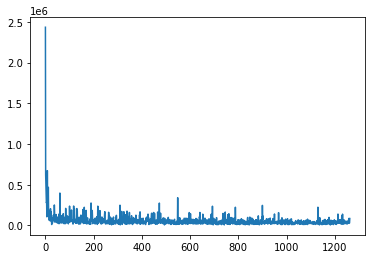

test loss progress:


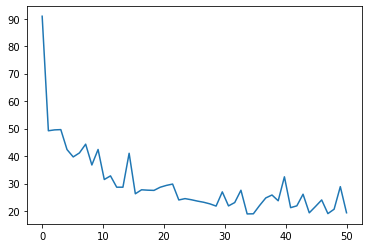

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[241,     0] train loss: 89.8248399099


KeyboardInterrupt: 

In [6]:
load_from_file = True
filepath = "./dispcolor3.pt"

train_losses = [] # network 2 losses [126.8147199172,345.1929051778,407.9061138246,487.2219051867,94.9551339021,515.6108290836,467.5951248803,178.5047332011,219.4922204112,383.7997970214,232.6194273986,98.9967008940,226.9864020100,155.3727015547,106.2453914082,207.1321223327,461.7718416180,183.5026874052,57.8208650137,349.4116798913,40.6712301996,142.6280784866,123.0570999886,99.8246419361,78.1380437288,204.7782604566,198.3235300414,101.9351791860,70.9115132606,84.1380906522,140.8556197232,448.9942929982,135.6107055063,702.0987234461,201.4258881361,82.3536545877,56.6271451223,171.3964114595,200.5718382430,209.2037754159,258.7238190166,135.3011661771,643.2428675108,126.6424102913,180.2784961861,118.9455020842,197.2826540061,80.6892756498,79.5956388327,228.7855985372,28.1844408261,515.7455250660,160.7191059937,133.4596892813,230.7270599763,214.2020819869,165.4794679442,113.9952639298,137.5980032165,33.7539164239,238.2274335142,71.2360292832,71.0185352529,348.3170616724,127.4333553699,75.0471906707,37.6223110648,176.9815620745,69.1666309333,55.6782656698,210.5747220757,243.3118970960,131.5546068584,146.2200852260,143.2946508593,75.2008933448,326.3596068454,422.6942134416,78.4934936851,676.7485469888,109.7159042649,259.9177605109,55.4426943370,88.6907719791,197.6759223596,153.2977573938,248.3758928720,71.8892056690,105.6930606427,84.4027124772,104.3970616716,138.2887111366,121.4008484441,244.5694526642,279.9267417237,158.8694347965,38.1868105767,112.3335151682,65.1154767772,86.8312415894,122.9823362974,300.1537115747,214.3239945953,111.0198302099,268.0433074587,132.5256944624,77.8975066595,538.5809420214,54.9872359066,220.6121301754,97.1399458517,233.5361047138,172.5432432902,238.4431738903,171.6820799439,178.6678651703,189.5308228322,346.0056103184,344.2085975871,207.0053425188,105.8496365846,355.6332315523,139.3442646098,129.0942770582,198.8367371503,387.9907486664,167.7813749894,68.5730633474,39.4034194229,237.7779481062,48.3341131429,174.8002122582,155.5929537171,179.2153110264,85.4595507589,47.5766898682,228.5852172568,100.4172372164,84.3028934950,87.6289162536,429.8593700398,171.2326338505,171.4077114981,67.8911075210,78.9001676101,276.7912352535,116.8861573635,88.3978313787,259.9150714848,80.9997911918,96.3362624522,163.1401774051,140.9056444722,66.4417577543,77.9011939364,121.3618119024,148.2605322251,224.5815770827,117.0795411812,579.2618026069,225.1267736999,70.4789125286,63.2062655808,180.8862002057,187.5305625122,211.1959444828,329.1850372556,187.4624448324,198.8050532464,65.9735782185,214.5772147985,107.9273249587,214.7995148646,275.0153870035,274.2527245599,120.3166287125,228.1842266221,104.2128585019,318.9894337423,119.2705407966,378.5607371504,124.9168759119,72.5276971690,152.6268473426,127.7965271190,292.0452753012,118.2987697033,93.4725458979,150.2675436806,241.7312449847,231.1721694901,491.3641266587,108.9458733112,199.2302165455,96.3528130146,78.9650151514,112.2967548485,203.6911564686,867.3784791920,228.2377119171,125.6746335445,66.7472482215,180.7269050802,68.9540232164,125.6396437283,119.7226125486,304.1371904022,144.2614840539,115.3823921190,285.5807569973,123.6718465851,79.7500989858,472.6873134293,80.4751264192,72.7165957562,252.3104586278,60.7778744364,44.0686078107,167.1927180750,629.2741570175,77.7273399275,519.7022667403,68.5675811480,236.0824732143,166.3715271916,98.9014100588,123.9656742075,757.1467704857,73.0721382607,169.1728286475,275.0835708588,60.3612811870,134.0575096894,115.1280617037,104.8359056228,82.8704053284,226.7365748343,160.5900039279,79.1405060915,51.5841129503,268.5709008693,109.8377845791,89.3093069474,117.9403960539,69.6014729681,77.4830872552,332.4489894075,77.3678653451,228.8352925301,735.2084230789,294.2777788815,155.0902041285,94.1921238534,240.8437330533,38.4299345394,69.2176861053,37.3972422443,156.3983574388,33.5695604521,51.2808802992,145.5613612589,102.5972560112,329.7188836529,190.4053140364,350.4570595325,265.2513961052,229.0808795816,254.2349708025,110.7917370898,100.6125061850,111.5873210558,82.2859958640,372.2710734260,175.3153184978,115.2785060215,145.8638459238,75.0490422454,63.9868652836,156.4017449719,411.4894442305,42.1818616543,192.2267555879,204.6947780647,139.2329708706,466.7719361521,104.5890311988,200.7232997365,260.9770490003,207.0881834221,261.9991939130,308.3916557587,19.4500142950,93.5817698782,118.1478931683,278.1612368960,130.0195993286,336.6469195293,221.5122274424,233.4649977757,56.0388745173,56.0762524559,175.6600804790,509.3368897639,221.9883765023,107.8452698605,78.6071141937,489.5445204432,115.7046564608,69.1266402782,225.3315697008,113.7773168040,82.5958428733,136.2577400730,163.0402437754,267.8894576598,221.6326443838,251.0199033961,111.4373085889,43.5078400183,95.4592929584,38.6165426805,91.2530673792,337.3874004380,79.6768383484,32.8857139194,148.3907893122,234.8697322240,257.2737722081,171.9403525711,235.4014045931,60.9644994877,253.5219679211,318.1423390058,87.7611788775,73.6056093373,90.3264847806,45.0869297986,244.6336828307,33.9398254476,165.8173454008,110.4734832111,63.9506664190,256.9598262166,375.1521787877,183.7748795029,172.7010166814,118.8748727828,95.4097548811,202.3763941417,109.0826977804,121.1006194891,316.1807626163,293.3348059095,274.3837769755,322.2099346321,184.0881273536,184.2423318393,307.2568095926,46.0558386126,244.8287363622]
test_losses = [] # network 2 losses [80.7745945096, 70.3584643063, 75.3331325148, 71.6508135511, 67.7817067810, 75.1355980648, 69.0844827324, 68.0399310178, 58.7731303799, 65.5964776811, 69.9211441996, 59.8682400744, 66.4159490535, 64.4955291238]

batchSize = 20
epochs = 2000
net = DispColorNet().to(torch.device(device))
mse_loss = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))

best_test_loss = float('inf')
e0 = 0
im0 = 0
if load_from_file:
    checkpoint = torch.load(filepath)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e0 = checkpoint['epoch']
    if 'train_losses' in checkpoint.keys():
        train_losses = checkpoint['train_losses']
    if 'test_losses' in checkpoint.keys():
        test_losses = checkpoint['test_losses']
    if 'best_test_loss' in checkpoint.keys():
        best_test_loss = checkpoint['best_test_loss']
else:
    # use He initialization if it's our first run on this file
    def init_weights(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            m.bias.data.fill_(0.01)
    net.apply(init_weights)


# send net to cuda device
# net.to(torch.device(device))
    
net.train() # set model to train mode

for epoch in range(e0, epochs):
    running_loss = 0
    try:
        for i, data in enumerate(train_dataloader):
            inp, featp, gtp, q = data
            # remove singleton dimension in the front
            inp = inp.squeeze()
            featp = featp.squeeze()
            gtp = gtp.squeeze()
            q = q.squeeze()
            running_loss = 0.0
            for b in range(0, inp.shape[0], batchSize):
                # create minibatch of size 20
                batch_inp = inp[b:min(b+batchSize, inp.shape[0]), :, :, :, :]
                batch_featp = featp[b:min(b+batchSize, inp.shape[0]), :, :, :]
                batch_gtp = gtp[b:min(b+batchSize, inp.shape[0]), :, :, :]
                batch_q = q

                # sent the batches to the gpu if possible
                batch_inp = batch_inp.to(device)
                batch_featp = batch_featp.to(device)
                batch_gtp = batch_gtp.to(device)
                batch_q = batch_q.to(device)

        #             print("batch_inp shape:")
        #             print(batch_inp.shape)
        #             print("batch_featp shape:")
        #             print(batch_featp.shape)
        #             print("batch_gtp shape:")
        #             print(batch_gtp.shape)

                batch_outp = net.forward(batch_inp, batch_featp, batch_q)
                loss = mse_loss(batch_outp, batch_gtp)

                optimizer.zero_grad() # zero the gradients before backward pass

                loss.backward()

                optimizer.step()

                running_loss += loss.item() * batchSize
            
            # print loss after every 20 images
            if i % 20 == 0:
                print('[%d, %5d] train loss: %.10f' %
                      (epoch, i, (running_loss * 255.0 * 255.0) / inp.shape[0])) # mult by 255*255 to get more readable numbers
                train_losses += [running_loss*255.0*255.0]
            # save weights after every 20 images
            if i % 20 == 0 and i != 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_test_loss': best_test_loss,
                    'train_losses': train_losses,
                    'test_losses': test_losses
                }, filepath)
                
        # calculate test loss every 5 epochs.  checkpoint [in new file] if test loss smaller than ever before
        if epoch % 5 == 0:
            print('Calculating test loss...')
            # set net to evaluate
            net.eval()
            test_loss = 0.0
            for i, data in enumerate(test_dataloader):
                inp, featp, gtp, q = data
                # remove singleton dimension in the front
                inp = inp.squeeze()
                featp = featp.squeeze()
                gtp = gtp.squeeze()
                q = q.squeeze()
                for b in range(0, inp.shape[0], batchSize):
                    # create minibatch of size 20
                    batch_inp = inp[b:min(b+batchSize, inp.shape[0]), :, :, :, :]
                    batch_featp = featp[b:min(b+batchSize, inp.shape[0]), :, :, :]
                    batch_gtp = gtp[b:min(b+batchSize, inp.shape[0]), :, :, :]
                    batch_q = q
                    # sent the batches to the gpu if possible
                    batch_inp = batch_inp.to(device)
                    batch_featp = batch_featp.to(device)
                    batch_gtp = batch_gtp.to(device)
                    batch_q = batch_q.to(device)

            #             print("batch_inp shape:")
            #             print(batch_inp.shape)
            #             print("batch_featp shape:")
            #             print(batch_featp.shape)
            #             print("batch_gtp shape:")
            #             print(batch_gtp.shape)

                    batch_outp = net.forward(batch_inp, batch_featp, batch_q)
                    test_loss += mse_loss(batch_outp, batch_gtp).item() * batchSize
            test_losses += [test_loss]
            if test_loss < best_test_loss: 
                print('Done with epoch %d.  Checkpointing with test loss %.10f' % 
                      (epoch, test_loss))
                best_test_loss = test_loss
                torch.save({
                        'epoch': epoch,
                        'model_state_dict': net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_test_loss': best_test_loss,
                        'train_losses': train_losses,
                        'test_losses': test_losses
                    }, './best3_loss_%d.pt' % int(test_loss))
            else:
                print('Done with epoch %d.  Test loss did not improve: %.10f; not checkpointing' % 
                      (epoch, test_loss))
            # set net to continue training
            net.train()
        # every 10 epochs, plot the graphs
        if epoch % 10 == 0 and epoch != 0:
            print("train loss progress:")
            x = np.linspace(0, len(train_losses), num=len(train_losses))
            plt.plot(x, np.array(train_losses))
            plt.show()
            print("test loss progress:")
            x = np.linspace(0, len(test_losses), num=len(test_losses))
            plt.plot(x, np.array(test_losses))
            plt.show()
    except RuntimeError as re:
        print("skipping an image due to: %s" % re)
        pass
            

<h3>Model Evaluation</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground truth:                                                 Network output:


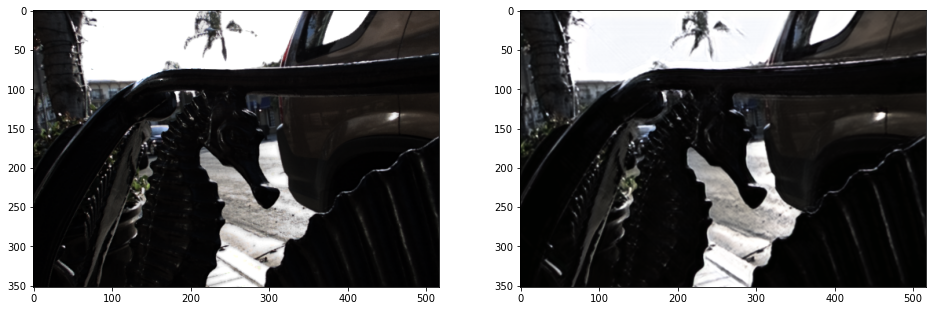

Predicted Disparity:


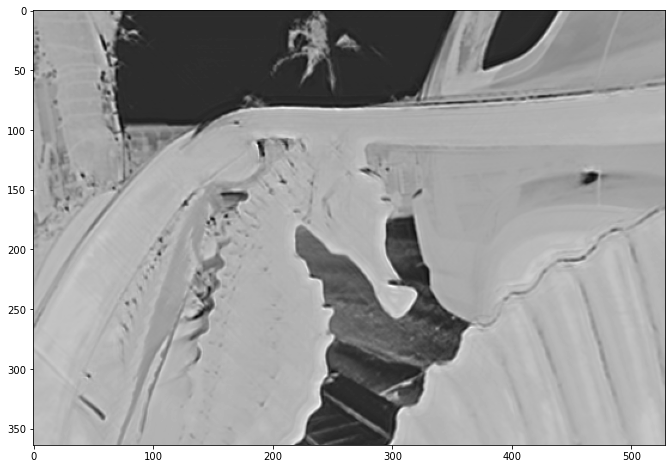

In [7]:
# evaluate model on a test image
def eval_on_image(im_path, net, q):
    net.eval()
    with torch.no_grad():
        # LOAD THE IMAGE AND TURN IT FROM LIGHTFIELD TO SEPARATED IMAGES
        img_path = im_path
        image = plt.imread(img_path)#torch.permute(read_image(img_path), (1, 2, 0)).float()
        numImgsX = 14
        numImgsY = 14
        h = int(image.shape[0] / numImgsY)
        w = int(image.shape[1] / numImgsX)
        fullLF = np.zeros((h, w, 3, numImgsX, numImgsY))
        for ax in range(numImgsX):
            for ay in range(numImgsY):
                #print(im1[ay::numImgsY, ax::numImgsX, :].shape)
                fullLF[:,:,:, ax, ay] = image[ay::numImgsY, ax::numImgsX, :3]
        if h == 375 and w == 540:
            np.pad(fullLF, ((0, 1), (0, 1), (0, 0), (0, 0), (0, 0)))
        if h == 375 and w == 541:
            np.pad(fullLF, ((0, 1), (0, 0), (0, 0), (0, 0), (0, 0)))
        fullLF = fullLF[:, :, :, 4:12, 4:12] # 8 middle images
        inr = np.array(((0, 0), (7, 7)))
        inc = np.array(((0, 7), (0, 7)))
        inLF = fullLF[:, :, :, inc, inr] # 4 corner images
#         print(inLF.shape)

        # CONVERT FULL AND INPUT LIGHTFIELDS TO TENSORS
        fullTens = torch.from_numpy(fullLF.copy()).float() # should be h x w x 3 x 8 x 8
        inTens = torch.from_numpy(inLF.copy()).float() # h x w x 3 x 2 x 2

        # CREATE THE INPUT, FEATURE, GROUND TRUTH PATCHES, AND REFERENCE VIEW FOR THE NETWORK
        # create input
        inP = torch.reshape(inTens, (h, w, 3, -1)) # h x w x 3 x 4
        in_eval = torch.permute(inP.unsqueeze(0), (0, 3, 4, 1, 2)) # 1 x h x w x 3 x 4 -> 1 x 3 x 4 x h x w for the network

        # load q into tensor
        q_eval = torch.tensor(q).long()

        # create feature patches
        disps = torch.linspace(disparity_range[0], disparity_range[1], 100)
        inTens_gray = 0.299*inTens[:, :, 0, :, :] + 0.587*inTens[:, :, 1, :, :] + 0.114*inTens[:, :, 2, :, :] #gray
        warped = back_warp(torch.reshape(inTens_gray, (h, w, 1, -1)), q_eval, disps) # h x w x 3(1) x 4 x disparity_levels
        warped = torch.squeeze(warped) # remove singleton dimension... gives h x w x 4 x disparity_levels
        mean_feat = torch.mean(warped, dim=2)
        stdev_feat = torch.sqrt((1.0/3.0)*torch.sum(torch.pow(warped - mean_feat.unsqueeze(2), 2), dim=2))
        featP = torch.cat((mean_feat, stdev_feat), dim=2) # h x w x 200
        feat_eval = torch.permute(featP.unsqueeze(0), (0, 3, 1, 2)) # 1 x h x w x 200 -> 1 x 200 x h x w for the network

        # create gt tensor
        gt = fullTens[12:-12, 12:-12, :, q_eval[0], q_eval[1]]
        
        # evaluate the network
        out_tens = net.forward(in_eval.to(device), feat_eval.to(device), q_eval.to(device))
        
        out_disp = net.d(feat_eval.to(device))
        
    # return tuple of the input, the features, the gt, and the final output
    return in_eval, feat_eval, gt, out_tens, out_disp

load_from_file = True
im_filepath = "../../../../../datasets/cs274-fa21-A00-public/TestSet/PAPER/Seahorse.png"
net_filepath = "./best3_loss_18.pt"
net = DispColorNet()

if load_from_file:
    checkpoint = torch.load(net_filepath, map_location='cpu')
    net.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e0 = checkpoint['epoch']

net.to(torch.device(device))

in_eval, feat_eval, gt, output, out_disp = eval_on_image(im_filepath, net, [3, 3])

print("Ground truth:                                                 Network output:")
# print(gt.cpu().numpy().shape)
plt.figure(figsize=(16, 12))
plt.subplot(121)
plt.imshow(gt)#.cpu().numpy())
plt.subplot(122)
plt.imshow(output[0, :, :, :].permute((1, 2, 0)).cpu().numpy())
plt.show()
print("Predicted Disparity:")
plt.figure(figsize=(12, 8))
plt.imshow(out_disp[0, :, :, :].permute((1, 2, 0)).cpu().numpy(), cmap='gray')
plt.show()

In [ ]:
print(train_losses)

In [ ]:
print(test_losses)

In [ ]:
filepath = "./dispcolor1.pt"
if load_from_file:
    checkpoint = torch.load(filepath)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e0 = checkpoint['epoch']
    if 'train_losses' in checkpoint.keys():
        train_losses = checkpoint['train_losses']
    if 'test_losses' in checkpoint.keys():
        test_losses = checkpoint['test_losses']
    if 'best_test_loss' in checkpoint.keys():
        best_test_loss = checkpoint['best_test_loss']


In [ ]:
torch.cuda.empty_cache()